# Introduction

In this notebook, I've used **CNN** to perform Image Classification on the Brain Tumor dataset.<br>
Since this dataset is small, if we train a neural network to it, it won't really give us a good result.<br>
Therefore, I'm going to use the concept of **Transfer Learning** to train the model to get really accurate results.

---

# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from shutil import copyfile
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
main_folder = '/kaggle/input/mritumor/Data'

# Find categories (subfolders) in the main folder
categories = [folder_name for folder_name in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder_name))]

# Create train and test folders
train_folder = 'MRIBrainTumor/Training'
test_folder = 'MRIBrainTumor/Testing'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Loop through each category
for category in categories:
    category_path = os.path.join(main_folder, category)

    # Find images in the category
    image_files = [os.path.join(category_path, file) for file in os.listdir(category_path) if file.endswith('.jpg')]

    # Split the data into train and test
    train_images, test_images = train_test_split(image_files, test_size=0.2, random_state=42)

    # Copy train images to the train folder
    for train_image in train_images:
        dest = os.path.join(train_folder, category, os.path.basename(train_image))
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        copyfile(train_image, dest)

    # Copy test images to the test folder
    for test_image in test_images:
        dest = os.path.join(test_folder, category, os.path.basename(test_image))
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        copyfile(test_image, dest)


In [3]:
# for dirname, _, filenames in os.walk('/kaggle/working/MRIBrainTumor'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

---

# Color

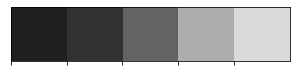

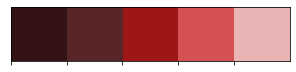

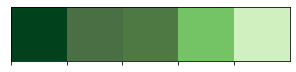

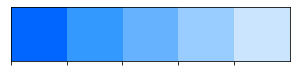

In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
colors_blue = ['#0066ff', '#3399ff', '#66b2ff', '#99ccff', '#cce5ff']
colors_purple = ['#4B0082', '#6A5ACD', '#9370DB', '#AB82FF', '#D8BFD8']

# You can adjust the brightness or add more shades based on your preference
sns.palplot(colors_dark)
sns.palplot(colors_red)
sns.palplot(colors_green)
sns.palplot(colors_blue)
# sns.palplot(colors_purple)

---

# Data Preperation

In [5]:
labels = ['glioma_tumor','normal','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [6]:
X_train = []
y_train = []
X_test = []
y_test = []

image_size = 150
for i in labels:
    folderPath = os.path.join('/kaggle/working/MRIBrainTumor','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/working/MRIBrainTumor','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 169/169 [00:00<00:00, 917.10it/s]


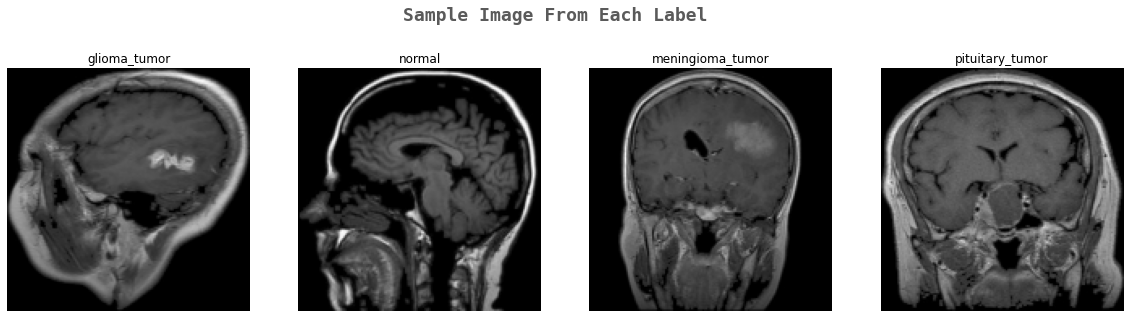

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

Dividing the dataset into **Training** and **Testing** sets.

In [9]:
# X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [10]:
X_train.shape

(2475, 150, 150, 3)

In [11]:
X_test.shape

(621, 150, 150, 3)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [13]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [14]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

We finally compile our model.

In [16]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [17]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

In [18]:
EPOCHS = 20
history = model.fit(X_train,y_train,validation_split=0.1, epochs =EPOCHS, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
70/70 [==============================] - 21s 161ms/step - loss: 0.7223 - accuracy: 0.6882 - val_loss: 0.5125 - val_accuracy: 0.8387

Epoch 00001: val_accuracy improved from -inf to 0.83871, saving model to effnet.h5
Epoch 2/20
70/70 [==============================] - 8s 113ms/step - loss: 0.2193 - accuracy: 0.9277 - val_loss: 0.5226 - val_accuracy: 0.8669

Epoch 00002: val_accuracy improved from 0.83871 to 0.86694, saving model to effnet.h5
Epoch 3/20
70/70 [==============================] - 8s 113ms/step - loss: 0.1334 - accuracy: 0.9550 - val_loss: 0.4146 - val_accuracy: 0.8952

Epoch 00003: val_accuracy improved from 0.86694 to 0.89516, saving model to effnet.h5
Epoch 4/20
70/70 [==============================] - 8s 113ms/step - loss: 0.1143 - accuracy: 0.9653 - val_loss: 0.3226 - val_accuracy: 0.9234

Epoch 00004: val_accuracy improved from 0.89516 to 0.92339, saving model to effnet.h5
Epoch 5/20
70/70 [==============================] - 8s 113ms/step - loss: 0.0694 - acc

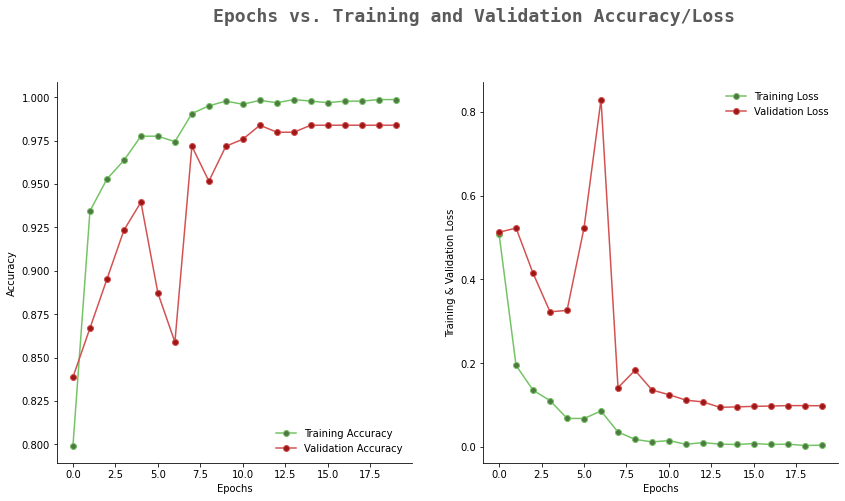

In [19]:
filterwarnings('ignore')

epochs = [i for i in range(EPOCHS)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [20]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [21]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       181
           1       0.96      1.00      0.98        88
           2       0.95      0.92      0.94       183
           3       0.99      0.99      0.99       169

    accuracy                           0.96       621
   macro avg       0.96      0.97      0.96       621
weighted avg       0.96      0.96      0.96       621



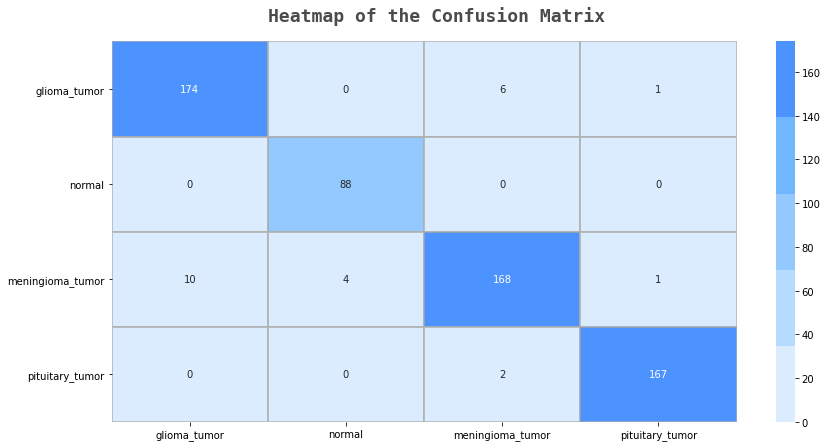

In [22]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_blue[::-1],
            alpha=0.7,
            linewidths=2,
            linecolor=colors_dark[3],
            fmt="d"
           )  # This sets the format of the colorbar ticks to integers

fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[0],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

In [23]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
        plt.imshow(img)
        plt.show()

    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

After uploading the image, you can click on the **Predict** button below to make predictions:

In [24]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [25]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])